In [405]:
import numpy as np
import pandas as pd
import scanpy as sc
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.4 scipy==1.9.3 pandas==1.5.1 scikit-learn==1.1.3 statsmodels==0.13.5 python-igraph==0.10.2 pynndescent==0.5.8


In [406]:
data1 = sc.read_10x_mtx(
    '../data/SC-HCC-P2-Tumor/20180416-HCC-P2-Tumor/filtered_gene_bc_matrices/hg19',
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)
data2 = sc.read_10x_mtx(
    '../data/SC-HCC-P3-Tumor/20180622-HCC-P3-Tumor-New/filtered_feature_bc_matrix',
    var_names = 'gene_symbols',
    cache=True)


... reading from cache file cache/..-data-SC-HCC-P2-Tumor-20180416-HCC-P2-Tumor-filtered_gene_bc_matrices-hg19-matrix.h5ad
... reading from cache file cache/..-data-SC-HCC-P3-Tumor-20180622-HCC-P3-Tumor-New-filtered_feature_bc_matrix-matrix.h5ad


In [407]:
data1.var_names_make_unique()
data2.var_names_make_unique()

In [408]:
sc.pp.filter_cells(data1, min_genes=200)
sc.pp.filter_genes(data1, min_cells=3)
data1.var['mt'] = data1.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(data1, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
data1 = data1[data1.obs.n_genes_by_counts < 2500, :]
data1 = data1[data1.obs.pct_counts_mt < 5, :]
sc.pp.normalize_total(data1, target_sum=1e4)
sc.pp.log1p(data1)
sc.pp.highly_variable_genes(data1, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.neighbors(data1, n_neighbors=10, n_pcs=40)

filtered out 14485 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes


/home/yuxin/.conda/envs/scanpy/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:07)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)


In [409]:
sc.pp.filter_cells(data2, min_genes=200)
sc.pp.filter_genes(data2, min_cells=3)
data2.var['mt'] = data2.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(data2, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
data2 = data2[data2.obs.n_genes_by_counts < 2500, :]
data2 = data2[data2.obs.pct_counts_mt < 5, :]
sc.pp.normalize_total(data2, target_sum=1e4)
sc.pp.log1p(data2)
sc.pp.highly_variable_genes(data2, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.neighbors(data2, n_neighbors=10, n_pcs=40)

filtered out 208 cells that have less than 200 genes expressed
filtered out 14411 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes


/home/yuxin/.conda/envs/scanpy/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:04)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)


In [410]:
sc.pp.neighbors(data1, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [411]:
sc.tl.leiden(data1)

running Leiden clustering
    finished: found 13 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [412]:
dd1 = data1.X.todense()

In [413]:
y = np.array([int(data1.obs['leiden'][i]) for i in range(dd1.shape[0])])
uni_dict = {0:0, 1:1, 2:2, 3:3, 4:4, 5:0, 6:5, 7:6, 8:0, 9:1, 10:0, 11:6, 12:7, 13:8}
for i in range(len(y)):
    y[i] = uni_dict[y[i]]
n_out = len(set(uni_dict.values()))

In [414]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
import matplotlib.pyplot as plt
from torch.autograd import Variable

class Net(nn.Module):
    def __init__(self,n_input,n_hidden,n_output):
        super(Net,self).__init__()
        self.hidden1 = nn.Linear(n_input,n_hidden)
        self.hidden2 = nn.Linear(n_hidden,n_hidden)
        self.predict = nn.Linear(n_hidden,n_output)
        # self.dropout = nn.Dropout(p=0.2)
    def forward(self,input):
        out = self.hidden1(input)
        # out = self.dropout(out)
        out = F.relu(out)
        out = self.hidden2(out)
        # out = self.dropout(out)
        out = F.relu(out)
        out = self.predict(out)
        # out = F.sigmoid(out)

        return out

In [415]:
l1 = data1.var.index
l2 = data2.var.index
mask1 = torch.zeros(len(l1)).bool()
mask2 = torch.zeros(len(l2)).bool()
for i in range(len(l1)):
    if l1[i] in l2:
        mask1[i] = 1
for i in range(len(l2)):
    if l2[i] in l1:
        mask2[i] = 1
# perturb2 = torch.zeros(mask2.sum())
# l1_taken = l1[mask1]
# l2_taken = l2[mask2]
# standard = list(l1_taken)
# for i in range(len(l2_taken)):
#     gene = l2_taken[i]
#     perturb2[i] = standard.index(gene)

In [416]:
# from copy import deepcopy
# ttt = deepcopy(perturb2)
# perturb2.sort()
# print((ttt==perturb2).all())

In [417]:
from sklearn.model_selection import train_test_split
input = torch.from_numpy(dd1[:,mask1]).cuda()
target = torch.from_numpy(y).cuda()
target = F.one_hot(target, num_classes=n_out).float()
X_train, X_test, y_train, y_test = train_test_split(input, target, test_size=0.1)
train_set = Data.TensorDataset(X_train, y_train)
val_set = Data.TensorDataset(X_test, y_test)
train_loader = Data.DataLoader(dataset=train_set, batch_size=64)
val_loader = Data.DataLoader(dataset=val_set, batch_size=1)

In [418]:
print(target.shape[1])
for i in range(target.shape[1]):
    print((y==i).sum())


9
1491
952
571
494
408
300
453
50
0


In [427]:
n_hidden = 500
n = Net(input.shape[1], n_hidden, n_out)
optimizer = torch.optim.SGD(n.parameters(),lr = 0.01)
loss_func = torch.nn.CrossEntropyLoss()
n = n.cuda()

In [428]:
epochs = 500
early_stop = 5
tmp = 0
best_acc = 0.0
for t in range(epochs):
    train_loss = 0.0
    val_loss = 0.0
    correct = 0
    total = 0
    # train
    for i, (inp, out) in enumerate(train_loader):
        optimizer.zero_grad()
        predict = n(inp)
        loss = loss_func(predict, out)
        loss.backward()
        optimizer.step()
        train_loss += loss.data
        correct += (torch.argmax(predict, dim=1) == torch.argmax(out, dim=1)).sum()
        total += out.shape[0]
    train_acc = correct / total
    # test
    correct = 0
    total = 0
    n.eval()
    for i, (inp, out) in enumerate(val_loader):
        predict = n(inp)
        loss = loss_func(predict, out)
        val_loss += loss.data
        predict = F.softmax(predict)
        correct += (torch.argmax(predict, dim=1) == torch.argmax(out, dim=1)).sum()
        total += out.shape[0]
    val_acc = correct / total
    if val_acc > best_acc:
        best_acc = val_acc
        tmp = 0
    else:
        tmp += 1
    if tmp > early_stop:
        break
    print(f'Epoch [{t}/{epochs}]: train loss {train_loss}, train acc {train_acc}, val loss {val_loss}, val acc {val_acc}')

/tmp/ipykernel_3119/790793658.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predict = F.softmax(predict)


Epoch [0/500]: train loss 125.1740951538086, train acc 0.3141040802001953, val loss 835.8173828125, val acc 0.32415252923965454
Epoch [1/500]: train loss 113.2467041015625, train acc 0.3508358895778656, val loss 769.3477172851562, val acc 0.42584747076034546
Epoch [2/500]: train loss 99.34751892089844, train acc 0.44078171253204346, val loss 683.6591186523438, val acc 0.3855932354927063
Epoch [3/500]: train loss 83.99878692626953, train acc 0.5366140604019165, val loss 599.323486328125, val acc 0.4512711763381958
Epoch [4/500]: train loss 70.843994140625, train acc 0.6187897324562073, val loss 508.5347595214844, val acc 0.5932203531265259
Epoch [5/500]: train loss 59.582275390625, train acc 0.6858959197998047, val loss 432.146484375, val acc 0.6631355881690979
Epoch [6/500]: train loss 50.224159240722656, train acc 0.7424063682556152, val loss 367.4164733886719, val acc 0.7245762944221497
Epoch [7/500]: train loss 41.49897766113281, train acc 0.7965622544288635, val loss 316.6351318359

In [429]:
dd2 = data2.X.todense()

In [430]:
input = torch.from_numpy(dd2[:,mask2]).cuda()
test_set = Data.TensorDataset(input)
test_loader = Data.DataLoader(dataset=test_set, batch_size=1)
predicts = []
for i, (inp,) in enumerate(test_loader):
    out = n(inp)
    out = F.softmax(out).detach().cpu()
    predict = torch.argmax(out, dim=1)[0].item()
    predicts.append(predict)


/tmp/ipykernel_3119/2565637452.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(out).detach().cpu()


In [431]:
tmp = pd.DataFrame(data=predicts, index=data2.obs.index)
new_cluster_names = [
    'Hepatocytes(1)', 'Macrophages(1)',
    'Enterocytes', 'Fibroblasts',
    'Proximal tubular cells', 'Hepatocytes(2)',
    'Pancreatic cells', 'NA(1)',
    'Hepatocytes(3)', 'Macrophages(2)',
    'Hepatocytes(4)', 'NA(2)',
    'Pancreatic endocrine cells', 'Smooth muscle cells'
    ]
new_cluster_dict = {i: new_cluster_names[i] for i in range(len(new_cluster_names))}
for i in tmp.index:
    tmp.at[i, 0] = new_cluster_dict[tmp.at[i, 0]]
print(tmp)
data2.obs['predicts'] = tmp

                                 0
AAACCTGCAAGCCGTC-1           NA(1)
AAACCTGCATGCTAGT-1  Hepatocytes(1)
AAACCTGGTATTAGCC-1           NA(1)
AAACCTGTCAACCAAC-1           NA(1)
AAACCTGTCCAGAGGA-1           NA(1)
...                            ...
TTTGTCAGTCGACTAT-1  Hepatocytes(1)
TTTGTCAGTTATGCGT-1           NA(1)
TTTGTCATCAATCTCT-1           NA(1)
TTTGTCATCTGTTTGT-1           NA(1)
TTTGTCATCTTGAGGT-1  Hepatocytes(1)

[4236 rows x 1 columns]


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


/home/yuxin/.conda/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


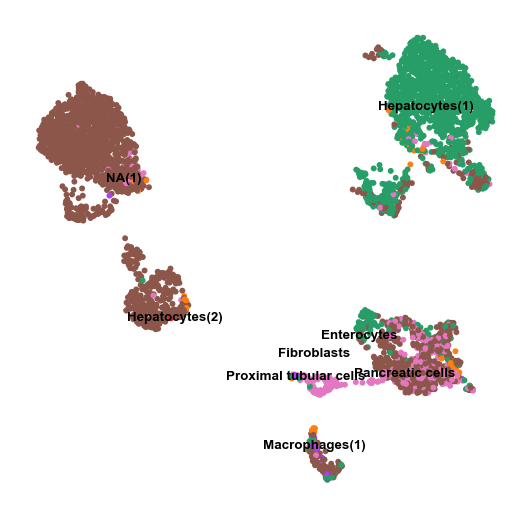

In [432]:
sc.tl.umap(data2)
# sc.pl.umap(data2, color=['predicts'])
sc.pl.umap(data2, color='predicts', legend_loc='on data', legend_fontsize=6, title='', frameon=False, save='.pdf')

In [433]:
for i in range(target.shape[1]):
    print((torch.tensor(predicts)==i).sum())

tensor(1323)
tensor(21)
tensor(1)
tensor(57)
tensor(1)
tensor(2)
tensor(342)
tensor(2489)
tensor(0)


running Leiden clustering
    finished: found 20 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/home/yuxin/.conda/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


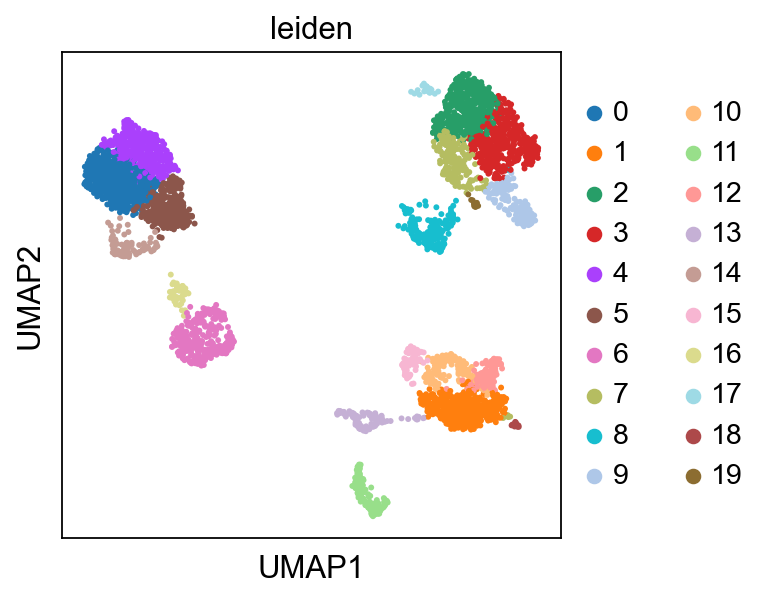

In [434]:
sc.tl.leiden(data2)
sc.pl.umap(data2, color=['leiden'])